# Betabank Customer Churn Prediction

This notebook presents a complete workflow for predicting customer churn for Betabank. The process includes data loading, exploratory data analysis, preprocessing, model training, evaluation, and final conclusions. Each step is explained in detail, and code cells are commented for clarity.

This project will analyze the effects of downsampling and oversampling techniques. 
First we will prepare our data without class balance adjustments to train candidate models. Aditionally, we will train the same candidates but this time we will balance the classes

# Account Closure Predictor for BetaBank Users

Beta Bank customers are leaving, little by little, every month. Bankers have discovered that it is cheaper to retain existing customers than to attract new ones.

We need to predict if a customer will leave the bank soon. You have data on past customer behavior and contract terminations with the bank.

We will Create a model with the highest possible F1 score. To pass the review, we set an F1 score of at least 0.59.

For this particullar project we will compare the AUC-ROC and F1-score metrics to correctly assess our candidates.

Data Description

Features

- RowNumber: data string index
- CustomerId: unique customer identifier
- Surname: last name
- CreditScore: credit score
- Geography: country of residence
- Gender: gender
- Age: age
- Tenure: period during which the client's fixed-term deposit has matured (years)
- Balance: account balance
- NumOfProducts: number of bank products used by the client
- HasCrCard: the client has a credit card (1 - yes; 0 - no)
- IsActiveMember: client activity (1 - yes; 0 - no)
- EstimatedSalary: estimated salary
- Target:
    - Exited: The client has left (1 - yes; 0 - no)

Project Evaluation
We have defined the evaluation criteria for the project. Read this carefully before proceeding to the exercise.


## Setup and Data Loading

The following libraries are used for data manipulation, machine learning, and evaluation metrics throughout this notebook.

In [1]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from utils import (
    plot_recall_precision_curve,
    calculate_optimal_threshold,
    plot_cv_results_by_resampler,
)

Now we will load the dataset and perform an initial exploration to understand its structure and contents.

Let's load our dataset to inspect the first records on it.

In [2]:
data = pd.read_csv("data/Churn.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Each record seems to include account, geographical and personal details of BetaBank costumers.  
Let's validate the presence of duplicated values.


In [3]:
data.duplicated().sum()

np.int64(0)

Now, it is necessary to be are aware of the exact types of data contained in the columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The result of the cell above shows that there are null values in the `Tenure` column, we will address those using several techniques in later steps. Regarding data types, it seems that they are valid to represent the values for the given features. However, if `Tenure` is measured in discrete periods of time, we could convert the data type of that column from float to int.

Before we continue any further with our analysis, features such as `Surname`, `RowNumber`, and `CustomerId` are not relevant for our purposes and will be removed from our dataset.
First, let's make sure there are not duplicated values in the `CustomerId` column.

In [5]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

The obtanined range of values for each feature, shows that we can safely remove those columns because there are no duplicated records for customers. If we had found any duplicated value, it would have been necessary to check all the information for those records.

In [6]:
data = data.drop(["CustomerId", "RowNumber", "Surname"], axis=1)

In [7]:
data.duplicated().sum()

np.int64(0)

Finally, our dataset includes only relevant data and we can continue with our analysis. 

Let's check a summary of statistics for numerical values.

In [8]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The summary of statistics in the previous output shows that the maximum and minimum values follow logical patterns. Moreover, the `Tenure` feature can be converted to integer data type. 

In [9]:
data["Tenure"] = data["Tenure"].astype("Int64")

In [10]:
X = data.drop(["Exited"], axis=1)
y = data["Exited"].squeeze()

In [11]:
X["BalanceSalaryRatio"] = X["Balance"] / X["EstimatedSalary"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Comparision of predictive model candidates:

As stated in the introduction, our objective is to identify BetaBank customers who are likely to close their accounts. This section will focus on comparing various models and techniques for handling an imbalanced dataset.

### Class imbalance

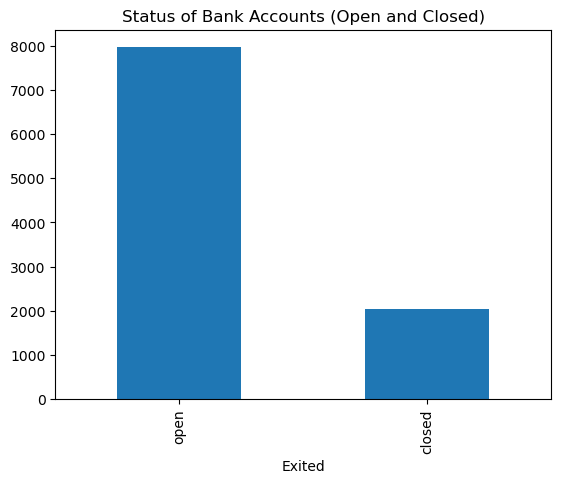

In [13]:
y.value_counts().plot(kind="bar", title="Status of Bank Accounts (Open and Closed)")
plt.xticks(ticks=[0, 1], labels=["open", "closed"])
plt.show()

Let's make predictions with the imbalance

### Predictive models candidates (Trained with imbalanced target)

Let's set a benchmark for our classification task using a model which asigns random class probabilities to every observation.

In [14]:
y_proba_dummy = np.random.rand(*y_train.shape)
best_threshold = calculate_optimal_threshold(y_train, y_proba_dummy)

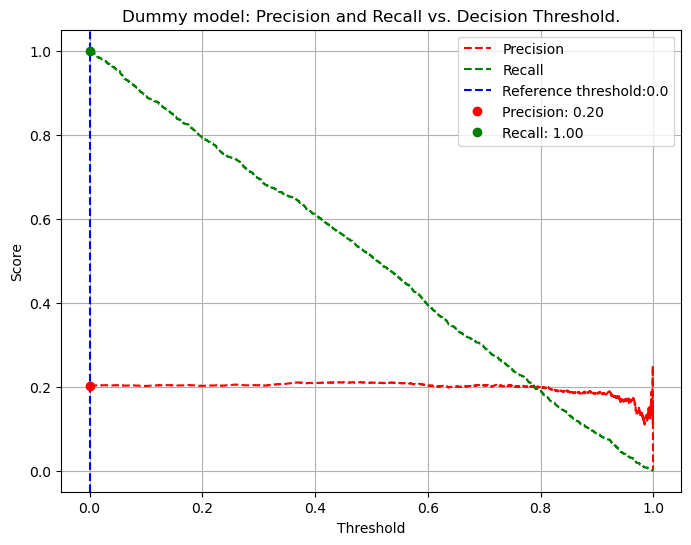

In [15]:
ax = plot_recall_precision_curve(y_train, y_proba_dummy, "Dummy model: Precision and Recall vs. Decision Threshold.", best_threshold)
plt.show()

Now that we have benchmark values for precision and recall, we can assess if our models are any better than just guessing.

Let's create a common preprocessing flow for our categorical and numerical data. This preprocessing flow will be used for models implementing class balance handling techniques and models that does not.

In [16]:
numeric_features = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
    "BalanceSalaryRatio",
]
categorical_features = ["Geography", "Gender"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

As the preprocessing flow is created we can proceed with the implmentation of pipelines that include our classification model. Let's start with `RandomForestClassifier`.

#### Random Forest classification

In [17]:
random_forest_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=1)),
    ]
)

For this candidate, we will perform a grid search for imputation technique and basic random forest hyperparameters such as number of trees and max tree depth.

In [18]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
    "classifier__n_estimators": [50, 100, 150, 200],
    "classifier__max_depth": [5, 10, 15],
}

In [19]:
rndm_forest_grid_search = GridSearchCV(
    random_forest_pipeline, param_grid, cv=5, scoring="roc_auc"
)

In [20]:
rndm_forest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary',
                                                                          'BalanceSalaryRatio']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'classifier__max_depth': [5, 10, 15],
                         'classifier__n_estimators': [50, 100, 150, 200],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']},
             scoring='roc_auc')

The optimized candidate will be used to find the best classification threshold. In our case, we will use a custom function that uses the Fβ-score with β=2 to find the best threshold. 

We are assuming that recall is twice (β=2) as important as precision because we want to identify as many customers who are about to exit as possible. 

Finally, for threshold optimization, we will use probabilities predicted using cross-validation on our training dataset due to the relatively small amount of data available to train and test our model. In ideal conditions, a validation dataset could be used to adjust our threshold, avoiding data leakage into our test dataset while also reducing overfitting on our training dataset.

In [21]:
y_oof_proba = cross_val_predict(
    rndm_forest_grid_search.best_estimator_,
    X_train,
    y_train,
    cv=5,
    method="predict_proba",
)[:, 1]

In [22]:
best_threshold = calculate_optimal_threshold(y_train, y_oof_proba)

Analyzing the precision-recall trade-off across the entire range of possible thresholds is a critical step in model optimization. The final threshold, however, must be selected by evaluating its impact on business-level metrics, including revenue, campaign costs, and ROI. The plot below illustrates this relationship and marks the threshold that maximizes the Fβ-score.

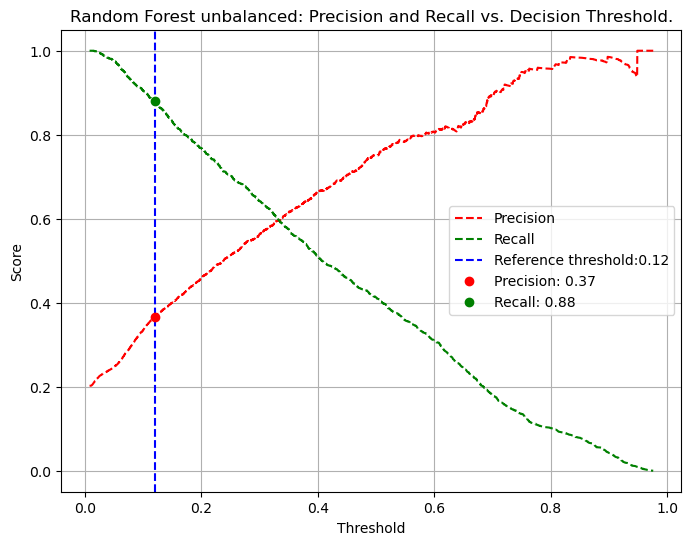

In [23]:
ax = plot_recall_precision_curve(y_train, y_oof_proba, "Random Forest unbalanced: Precision and Recall vs. Decision Threshold.", best_threshold)
plt.show()

As the plot illustrates, the `RandomForestClassifier` model offers a substantial performance improvement over the benchmark. By setting the optimized threshold to 0.14, we achieve a precision of approximately 0.4 and a recall of over 0.8. In business terms, this means the model correctly identifies over 80% of all at-risk customers, and 40% of its warnings about potential churn are accurate.

In [24]:
y_prob = rndm_forest_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
final_beta_score = fbeta_score(y_test, y_prob>=best_threshold, beta=2)
final_beta_score

0.6894429055093875

#### Logistic regression

Our second candidate is the classic `LogisticRegression` classifier. We will repeat the steps we followed for our previous candidate.

In [25]:
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In this case, we will only optimize imputation strategy.

In [26]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"]
}

In [27]:
log_reg_grid_search = GridSearchCV(
    log_reg_pipeline, param_grid, cv=5, scoring="roc_auc"
)

In [28]:
log_reg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary',
                                                                          'BalanceSalaryRatio']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']},
             scoring='roc_auc')

Once we have found our best estimator, we can proceed to the threshold optimization.

In [29]:
y_oof_proba = cross_val_predict(
    log_reg_grid_search.best_estimator_, X_train, y_train, cv=5, method="predict_proba"
)[:, 1]

In [30]:
best_threshold = calculate_optimal_threshold(y_train, y_oof_proba)

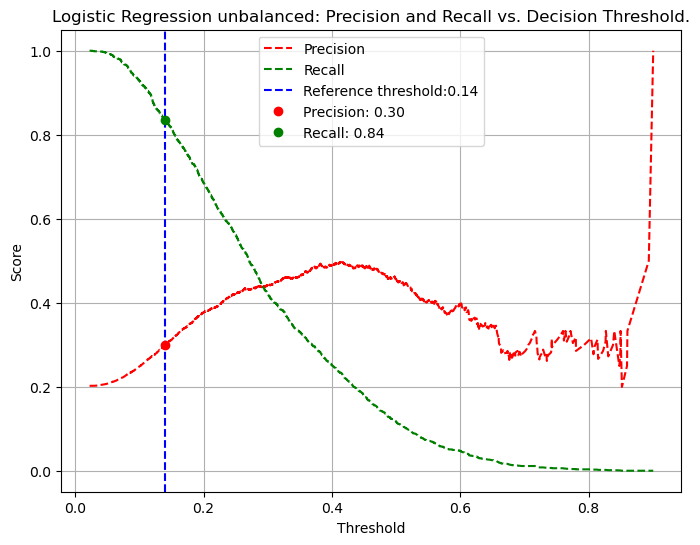

In [31]:
ax = plot_recall_precision_curve(y_train, y_oof_proba,  "Logistic Regression unbalanced: Precision and Recall vs. Decision Threshold.", best_threshold,)
plt.show()

This plot shows that the `LogisticRegression` estimator has an inferior performance to the `RandomForestClassifier` but is still an improvement over our benchmark model. By setting the optimized threshold to 0.16, precision falls below 0.4 and recall remains at 0.8. In business terms, this means the model correctly identifies over 80% of all at-risk customers, and less than 40% of its warnings about potential churn are accurate. Even though the recall is high (80%), the number of false positives has a negative impact on the total cost of the campaign.

In [32]:
y_prob = log_reg_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
final_beta_score = fbeta_score(y_test, y_prob>=best_threshold, beta=2)
final_beta_score

0.6330749354005168

## Handling class imbalance

In this section, we will implement some class-imbalance handling techniques to train the same candidates we used in the previous section. 

To correct for the class imbalance in our data, we will run a grid search comparing several handling techniques. This search will include SMOTE (testing k-values of 2, 3, and 5), which creates synthetic data, as well as random over-sampling (duplicating minority class samples) and random under-sampling (removing majority class samples).

### Random Forest

In [33]:
rnd_forest_imb_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampler", "passthrough"),
        ("classifier", RandomForestClassifier(random_state=1, bootstrap=True)),
    ]
)

param_grids = [
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [RandomOverSampler(random_state=1)],
        "resampler__sampling_strategy": ["minority", 0.75, 0.50],
        "classifier__max_depth": [3, 7, 12],
        "classifier__n_estimators": [150, 200, 250],
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [RandomUnderSampler(random_state=1)],
        "resampler__sampling_strategy": ["majority", 0.75, 0.50],
        "resampler__replacement": [True, False],
        "classifier__max_depth": [3, 7, 12],
        "classifier__n_estimators": [150, 200, 250],
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [SMOTE(random_state=1)],
        "resampler__k_neighbors": [10, 3, 500],
        "classifier__max_depth": [3, 7, 12],
        "classifier__n_estimators": [150, 200, 250],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": ["passthrough"],
        "classifier__max_depth": [3, 7, 12],
        "classifier__n_estimators": [150, 200, 250],
        "classifier__class_weight": [None, "balanced"],
    },
]


grid_search = GridSearchCV(
    rnd_forest_imb_pipeline, param_grids, cv=5, scoring="f1", n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary',
                                                                          'BalanceSalaryRatio']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        ha...
                          'preprocessor__num__imputer__strategy': ['mean',
                                                                   'median',
                                                                   'most_frequent'],
                          'resampler': [SMOTE(random_state=1)],
                          'resampler__k_neighbors': [10, 3, 500]},
                         {'classifier__class_weight': [None, 'balanced'],
                          'classifier__max_depth': [3, 7, 12],
                          'classifier__n_estimators': [150, 200, 250],
                          'preprocessor__num__imputer__strategy': ['mean',
                                                                   'median',
                                                                   'most_frequent'],
                          'resampler': ['passthrough']}],
             scoring='f1')

We optimize the threshold following the previously mentioned approach.

In [34]:
y_oof_proba = cross_val_predict(
    grid_search.best_estimator_, X_train, y_train, cv=5, method="predict_proba"
)[:, 1]

In [35]:
rnd_forest_optimal_threshold = calculate_optimal_threshold(y_train, y_oof_proba)

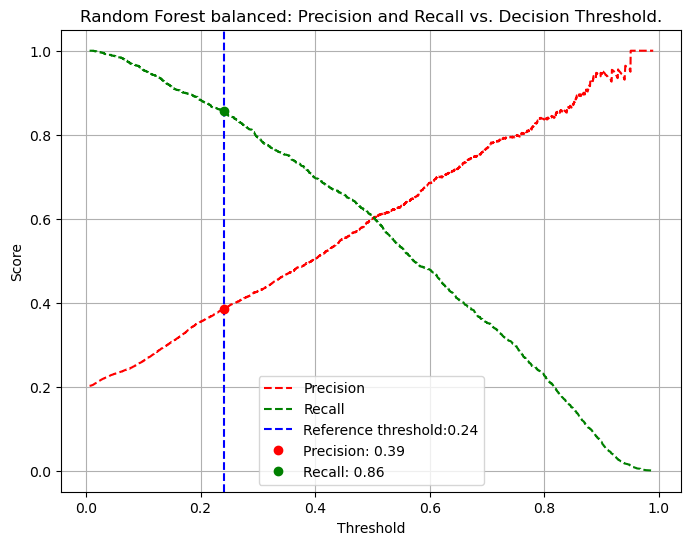

In [36]:
ax = plot_recall_precision_curve(y_train, y_oof_proba,  "Random Forest balanced: Precision and Recall vs. Decision Threshold.", rnd_forest_optimal_threshold)
plt.show()

This plot shows that the `RandomForestClassifier` estimator does not improve when using class-imbalance handling techniques. Same as the model without imbalance handling, the optimized threshold is 0.14, precision is 0.4 and recall is over 0.8. In business terms, this means the model correctly identifies over 80% of all at-risk customers, and 40% of its warnings about potential churn are accurate.

In [37]:
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results["param_classifier__class_weight"] = cv_results[
    "param_classifier__class_weight"
].fillna("None")

cv_results["param_resampler"] = cv_results["param_resampler"].fillna("passthrough")

In [38]:
resampler_params_map = {
    "passthrough" : "N/A",
    "RandomUnderSampler": "sampling_strategy",
    "RandomOverSampler": "sampling_strategy",
    "SMOTE": "k_neighbors",
}

plot_params = {
    "x": "hyperparameter_value",
    "y": "mean_test_score",
    "col": "resampler_name",
    "kind": "violin",
    "height": 5,
    "hue": "param_classifier__class_weight",
    "aspect": 1.1,
    "sharex": False,
    "col_wrap": 2
}

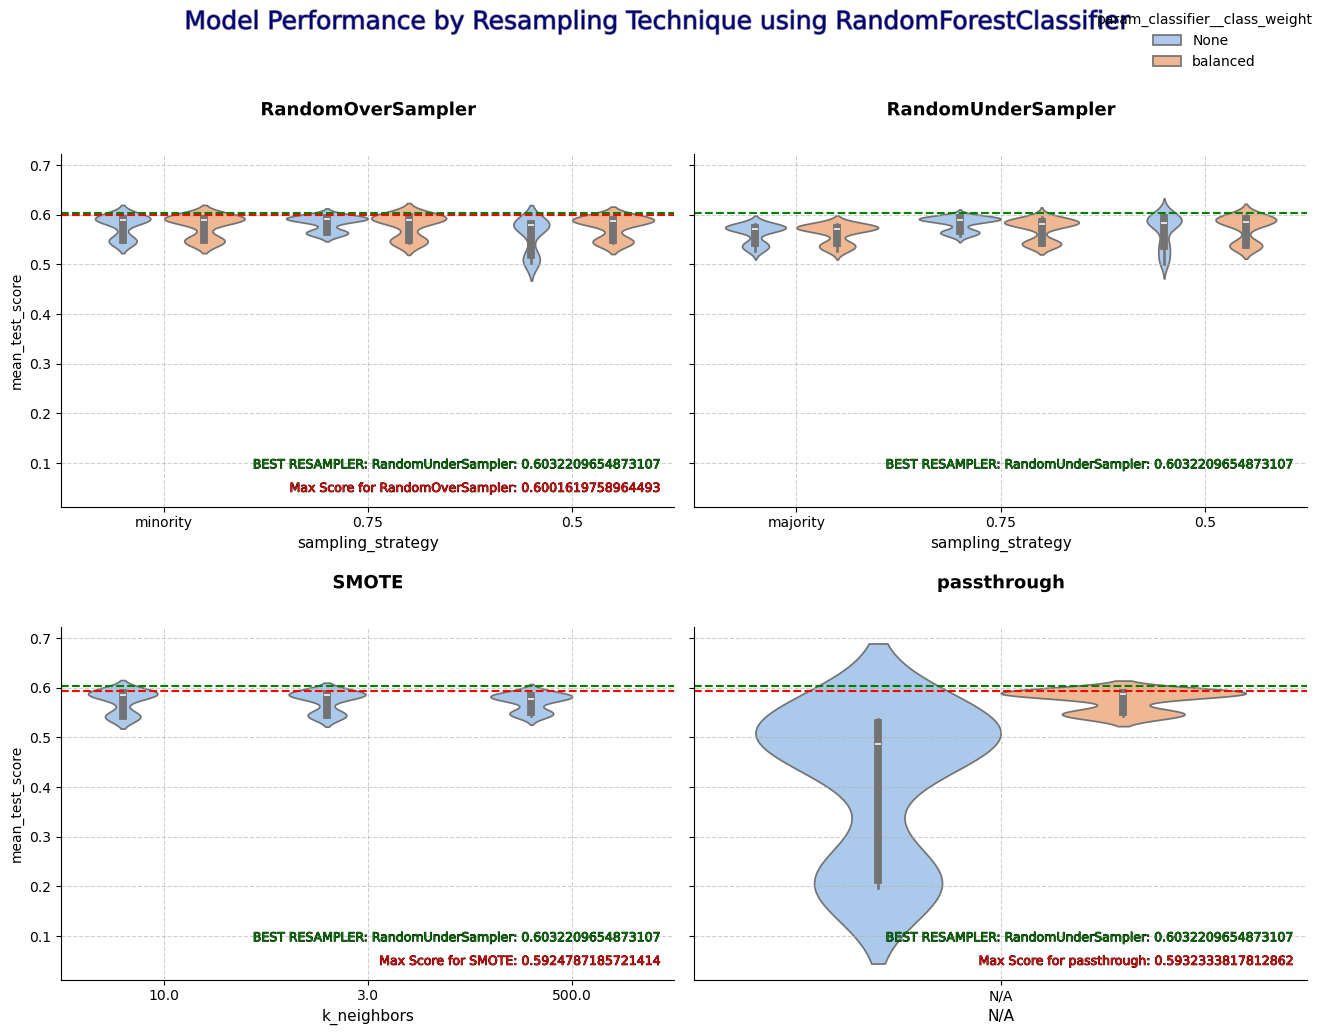

In [39]:
ax = plot_cv_results_by_resampler(
    cv_results,
    resampler_params_map,
    title="Model Performance by Resampling Technique using RandomForestClassifier",
    plot_params=plot_params
)

plt.show()



In [40]:
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
final_beta_score = fbeta_score(y_test, y_prob>=rnd_forest_optimal_threshold, beta=2)
final_beta_score

0.6926546391752577

### Logistic Regression binary classification

In [41]:
logistic_reg_imb_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampler", "passthrough"),
        ("classifier", LogisticRegression(random_state=1)),
    ]
)

param_grids = [
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [SMOTE(random_state=1)],
        "resampler__k_neighbors": [40, 50, 60],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [RandomOverSampler(random_state=1)],
        "resampler__sampling_strategy": ["minority", 0.75, 0.85],
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "resampler": [RandomUnderSampler(random_state=1)],
        "resampler__sampling_strategy": ["majority", 0.75, 0.85],
        "resampler__replacement": [True, False],
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
        "classifier__class_weight": [None, "balanced"],
    },
]

log_reg_balanced_grid_search = GridSearchCV(
    logistic_reg_imb_pipeline, param_grids, cv=5, scoring="roc_auc", error_score='raise'
)

log_reg_balanced_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary',
                                                                          'BalanceSalaryRatio']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEnc...
                          'preprocessor__num__imputer__strategy': ['mean',
                                                                   'median',
                                                                   'most_frequent'],
                          'resampler': [RandomUnderSampler(random_state=1)],
                          'resampler__replacement': [True, False],
                          'resampler__sampling_strategy': ['majority', 0.75,
                                                           0.85]},
                         {'classifier__class_weight': [None, 'balanced'],
                          'preprocessor__num__imputer__strategy': ['mean',
                                                                   'median',
                                                                   'most_frequent']}],
             scoring='roc_auc')

In [42]:
y_oof_proba = cross_val_predict(
    log_reg_balanced_grid_search.best_estimator_,
    X_train,
    y_train,
    cv=5,
    method="predict_proba",
)[:, 1]

In [43]:
best_threshold = calculate_optimal_threshold(y_train, y_oof_proba)

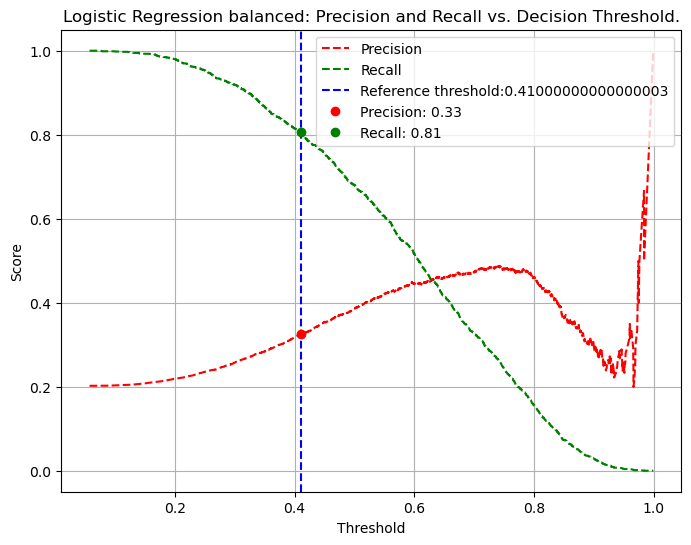

In [44]:
ax = plot_recall_precision_curve(y_train, y_oof_proba, "Logistic Regression balanced: Precision and Recall vs. Decision Threshold.",  best_threshold)
plt.show()

This plot shows that the `LogisticRegression` estimator has an inferior performance to the `RandomForestClassifier` but is still an improvement over our benchmark model. By setting the optimized threshold to 0.16, precision falls below 0.4 and recall remains at 0.8. In business terms, this means the model correctly identifies over 80% of all at-risk customers, and less than 40% of its warnings about potential churn are accurate. Even though the recall is high (80%), the number of false positives has a negative impact on the total cost of the campaign.

In [45]:
cv_results = pd.DataFrame(log_reg_balanced_grid_search.cv_results_)

cv_results["param_classifier__class_weight"] = cv_results[
    "param_classifier__class_weight"
].fillna("None")

cv_results["param_resampler"] = cv_results["param_resampler"].fillna("passthrough")

In [46]:
resampler_params_map = {
    "passthrough" : "N/A",
    "RandomUnderSampler": "sampling_strategy",
    "RandomOverSampler": "sampling_strategy",
    "SMOTE": "k_neighbors",
}

plot_params = {
    "x": "hyperparameter_value",
    "y": "mean_test_score",
    "col": "resampler_name",
    "kind": "violin",
    "height": 5,
    "hue": "param_classifier__class_weight",
    "aspect": 1.1,
    "sharex": False,
    "col_wrap": 2
}

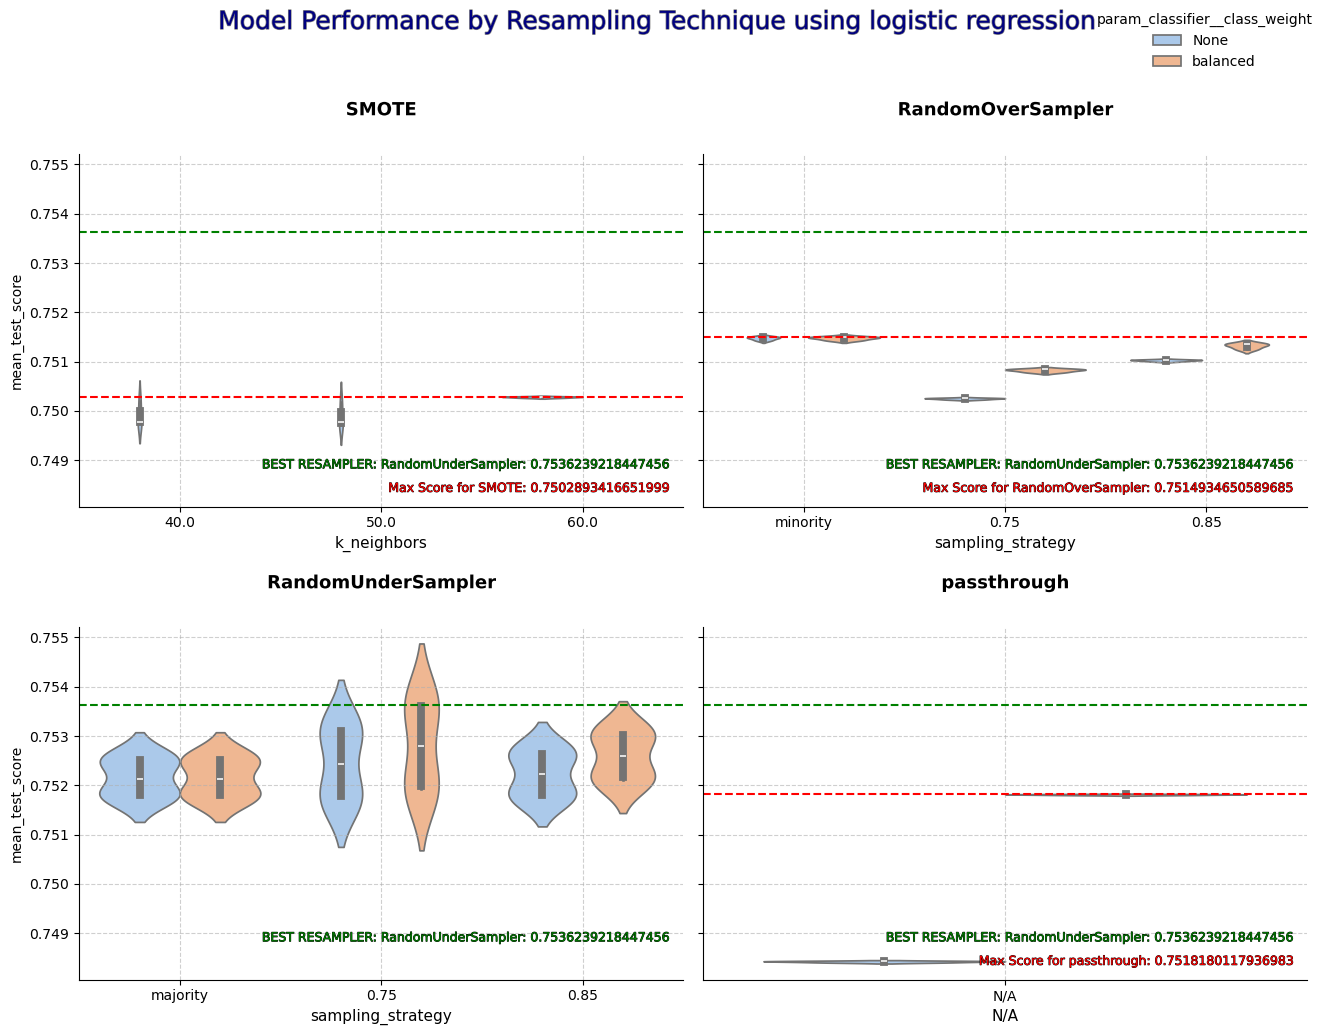

In [47]:
ax = plot_cv_results_by_resampler(
    cv_results,
    resampler_params_map,
    title="Model Performance by Resampling Technique using logistic regression",
    plot_params=plot_params
)

plt.show()

In [48]:
y_prob = log_reg_balanced_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
final_beta_score = fbeta_score(y_test, y_prob>=rnd_forest_optimal_threshold, beta=2)
final_beta_score

0.6015307342740971

## Conclusion

Random Forest Classifier are less susceptible to the effect of using imbalanced classes in our classification target. We could conclude that the internal implementations of RandomForest to handle imbalanced classes are more effective than Upsampling and downsampling